In [1]:
#Získanie informácií o projekte
from google.datalab import Context
context = Context.default()
project = Context.default().project_id  #ziskanie sucasneho id Google cloud projektu 
print('The current project is %s' % context.project_id)

#import sys -- zakomentovane pre ucely modelovacej casti, pretoze pri kodovani utf-8 ostava nefunkcny prikaz print
#reload(sys)
#sys.setdefaultencoding('utf-8')

import warnings; warnings.simplefilter('ignore') #ignorovanie hlaseni napr. o novych verziach balikov vo vysledkoch 

The current project is thesis-180707


# Identifikácia problému

- Verejné obstarávania sa podieľajú na celkovom HDP EÚ až 14%-ami.
- SR a ČR sa umiestnili medzi najhoršími krajinami v EÚ v celkovom hodnotení Európskej komisie. Kritériami boli konkurencia, transparentnoť, či komplexnosť zákaziek. 
- Správa European Anti-Fraud Office (OLAF) z 2016 označila SR za výrazne najhoršiu z EÚ v podvodných trasankciách pri eurofondoch.

# Cieľ

- Identifikovanie neefektívnych verejných obstarávaní pomocou strojového učenia. 
- Pomocou modelov budú verejnosť, združenia, uchádzači o zákazky a vláda schopní efektívnejšie identifikovať problémové zákazky už pri ich vyhlásení. 
- Potenciál zlepšiť obraz verejných obstarávaní v SR a zlepšiť celkové hodnotenie oproti krajinám EÚ. 

In [2]:
#Načítanie dát z dvoch csv súborov uložených v Google cloud storage
#Dáta sa týkajú oznámení a výziev verejných zákazok v SR od roku 2014 do polovice roka 2017
import pandas as pd
from matplotlib import pyplot as plt 
import google.datalab.storage as storage
import io
bucket = storage.Bucket('thesis-180707')
print(bucket) #overenie, ze bucket existuje
vyzvy_objekt = bucket.object('vyzvy_jul.csv') #overenie, ze objekt existuje
oznamenia_objekt = bucket.object('oznamenia_jul.csv')
print(vyzvy_objekt,oznamenia_objekt)

%gcs read --object gs://thesis-180707/data_diplom/vyzvy_sept.csv --variable vyzvy 
df_vyzvy = pd.read_csv(io.BytesIO(vyzvy))

%gcs read --object gs://thesis-180707/data_diplom/oznamenia_jul.csv --variable oznamenia
df_oznamenia = pd.read_csv(io.BytesIO(oznamenia))

%gcs read --object gs://thesis-180707/data_diplom/oznamenia_septem.csv --variable oznamenia_septem
df_oznamenia_septem = pd.read_csv(io.BytesIO(oznamenia_septem))

frames = [df_vyzvy, df_oznamenia,df_oznamenia_septem] #list pre metodu concat
df = pd.concat(frames,ignore_index=True) # union dvoch datasetov a vytvori jeden unikatny index pre kazdy zaznam
print(df.shape)

df.head()

Google Cloud Storage Bucket gs://thesis-180707
(Google Cloud Storage Object gs://thesis-180707/vyzvy_jul.csv, Google Cloud Storage Object gs://thesis-180707/oznamenia_jul.csv)
(2515, 33)


,bude_sa_opakovat_zakazka,contracting_authority_name,cpv_others,deli_sa_casti,dlzka_zakazky_cleaned,druh_obstaravatela_clean,druh_postupu,druh_zakazky,el_aukcia,estimatedprice_from_result,...,published_on,total_final_value_amount_clean,total_final_value_amount_minus_vat,total_final_value_vat_included,total_final_value_vat_rate,typ_ceny_oznamenia,typ_obdobie,ucast_deadline,varianty,ziskanie_podkladov_deadline
0,NaN,"Slovenská technická univerzita v Bratislave, Ú...",NaN,Nie,12.0,OP - ORGANIZÁCIA RIADENÁ VEREJNÝM PRÁVOM,výzva,Práce,Nie,NaN,...,2015-06-09,523318.90,NaN,NaN,NaN,Jedna hodnota,v mesiacoch (od zadania zákazky),2015-06-29,NaN,2015-06-29
1,NaN,Obec Lovce,NaN,Nie,2.0,RO - REGIONÁLNY ALEBO MIESTNY ORGÁN,výzva,Práce,Nie,NaN,...,2015-12-15,96710.43,NaN,NaN,NaN,Jedna hodnota,v mesiacoch (od zadania zákazky),2016-01-05,NaN,2016-01-05
2,NaN,Obec Slovenská Nová Ves,NaN,Nie,2.0,RO - REGIONÁLNY ALEBO MIESTNY ORGÁN,výzva,Práce,Nie,NaN,...,2015-12-15,61583.32,NaN,NaN,NaN,Jedna hodnota,v mesiacoch (od zadania zákazky),2016-01-05,NaN,2016-01-05
3,NaN,Obec Muránska Lehota,NaN,Nie,2.0,RO - REGIONÁLNY ALEBO MIESTNY ORGÁN,výzva,Práce,Nie,NaN,...,2015-12-03,82298.45,NaN,NaN,NaN,Jedna hodnota,v dňoch (od zadania zákazky),2015-12-23,NaN,2015-12-23
4,NaN,Obec Prusy,NaN,Nie,2.0,RO - REGIONÁLNY ALEBO MIESTNY ORGÁN,výzva,Práce,Nie,NaN,...,2015-12-04,96318.58,NaN,NaN,NaN,Jedna hodnota,v dňoch (od zadania zákazky),2015-12-23,NaN,2015-12-23


In [3]:
#!pip install -U imbalanced-learn #instalacia extra kniznice, ktora nie je standardne sucastou sklearn pre test under-sampling, over-samplingu ... 

In [3]:
#vytvorenie cieloveho atributu, kde za neefektívne vysúťažené zákazky sú považované zákazky s pomerom odhadovanej a finálnej ceny 
#minimálne na úrovni 100%. Takto definované zákazky budú označované aj ako neefektívne. 
def CreateTarget(ratio):  
    if ratio >= 1:
        return 1
    else:
        return 0
    
df['target'] = df['price_ratio'].map(CreateTarget)
df['target'].value_counts()

0    2019
1     496
Name: target, dtype: int64

In [4]:
df_clean = df[['hlavna_cinnost_clean','druh_obstaravatela_clean','contracting_authority_name','druh_postupu','druh_zakazky','main_cpv_code','typ_obdobie','dlzka_zakazky_cleaned','kriteria_ponuk','el_aukcia','eu_fondy','estimatedpricecleaned','nazov_typu_oznamenia','miesto_prac_zakazky','target']]

# Porozumenie a príprava dát

In [6]:
df.columns #Dostupné atribút

Index([u'bude_sa_opakovat_zakazka', u'contracting_authority_name',
       u'cpv_others', u'deli_sa_casti', u'dlzka_zakazky_cleaned',
       u'druh_obstaravatela_clean', u'druh_postupu', u'druh_zakazky',
       u'el_aukcia', u'estimatedprice_from_result', u'estimatedpricecleaned',
       u'eu_fondy', u'hlavna_cinnost_clean', u'kriteria_ponuk',
       u'main_cpv_code', u'miesto_prac_zakazky', u'nazov_typu_oznamenia',
       u'odoslanie_oznamenia', u'oznam_title', u'pocet_prijatych_el_ponuk',
       u'pocet_prijatych_ponuk', u'predch_uverejnen_zakazky', u'price_ratio',
       u'published_on', u'total_final_value_amount_clean',
       u'total_final_value_amount_minus_vat',
       u'total_final_value_vat_included', u'total_final_value_vat_rate',
       u'typ_ceny_oznamenia', u'typ_obdobie', u'ucast_deadline', u'varianty',
       u'ziskanie_podkladov_deadline', u'target'],
      dtype='object')

Nasledujúca sekcia je venovaná porozumeniu a príprave dát pomocou vyzualizácií a tiež využitím balíka Pandas pre transformáciu dát.

Pearsonova korelácia medzi numerickými premennými ukázala napríklad vyššiu koreláciu medzi cieľovým atribútom a dĺžkou trvania zákazky. Potvrdil sa tiež prvotný odhad negatívnej korelácie medzi pomerom odhadovanej a finálnej ceny (price_ratio) a počtom prijatých ponúk. Negatívna korelácia existuje tiež medzi touto premennou a dĺžkou trvania zákazky. Je potrebné podotknúť, že niektoré premenné sú pomocné a vysoké korelácie sú brané na vedomie, preto niektoré z nich nevstupujú do finálneho prediktívneho modelu. Zaujímavé vzťahy medzi atribútmi budú bližšie znázornené na jednotlivých vizualizáciách.

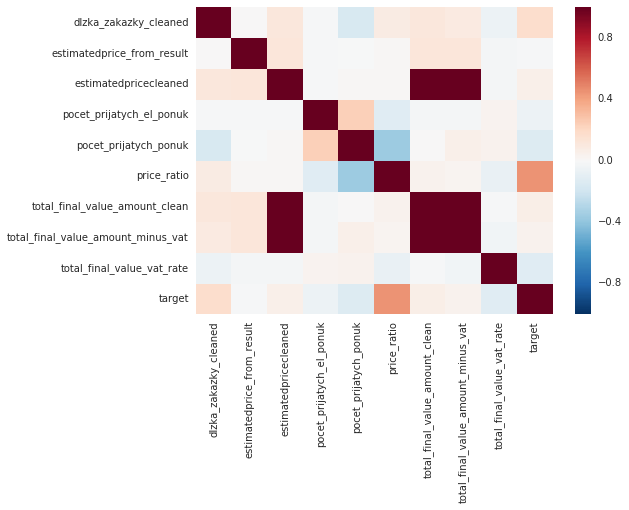

In [7]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr)

Nasledujúci graf znázorňuje vzťah medzi priemerným počtom prijatých ponúk na zákazku a pomer odhadovanej a finálnej ceny. Táto jednoduchá analýza znázorňuje pomerne dôležité zistenie. Čím nižšia konkurencia alebo súťaž totiž bola v zákazke pripustená, tým "drahšia" zákazka obecne bola. Z tohto grafu teda vyplýva, že drahšie zákazky mohli mať často nesprávne definované podmienky súťaže, prípadne iným spôsobom obmedzovať súťaž. Táto časť preto dokazuje, že tvorba prediktívneho modelu odhalujúceho neefektívne zákazky dáva zmysel a môže okrem iného podporiť vyššiu súťaž.

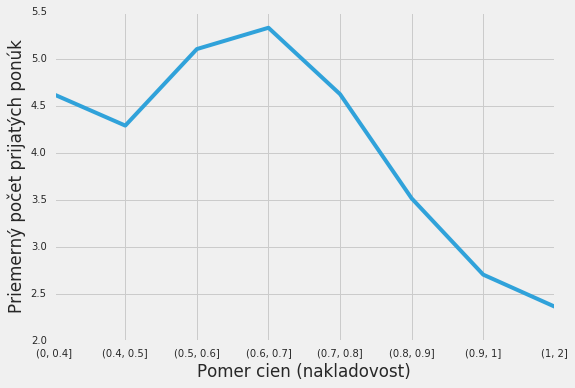

In [25]:
plt.style.use('fivethirtyeight')
bins = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]
df['categories'] = pd.cut(df['price_ratio'], bins)
df.head()
df.groupby('categories')['pocet_prijatych_ponuk'].mean().plot(kind = 'line',)
plt.ylabel('Priemerný počet prijatých ponúk')
plt.xlabel('Pomer cien (nakladovost)')


Nasledujúca vizualizácia zobrazuje, že neefektívne zákazky v priemere trvajú výrazne dlhšie. Odporúčania tejto práce sú preto zamerať sa na zákazky s vysokou dĺžkou trvania pri ich skúmaní. Obstarávatelia tiež majú možnosť v niektorých prípadoch rozdeliť dlhotrvajúce a komplexné zákazky na menšie časti, ktoré majú tendenciu byť úspešnejšie a tiež podporiť súťaž zapojením malých a stredných podnikov. 

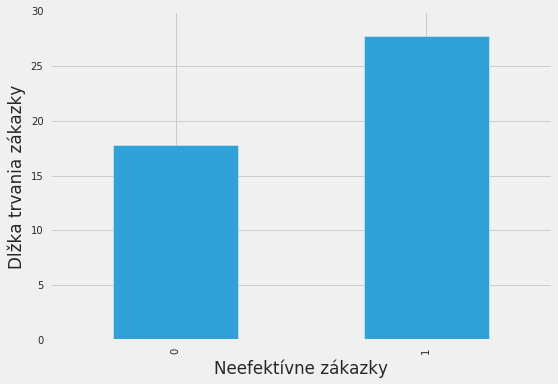

In [28]:
from matplotlib import pyplot as plt 

ax1 = df.groupby('target')['dlzka_zakazky_cleaned'].mean()

ax1.plot(kind = 'bar')
plt.ylabel('Dlžka trvania zákazky')
plt.xlabel('Neefektívne zákazky')

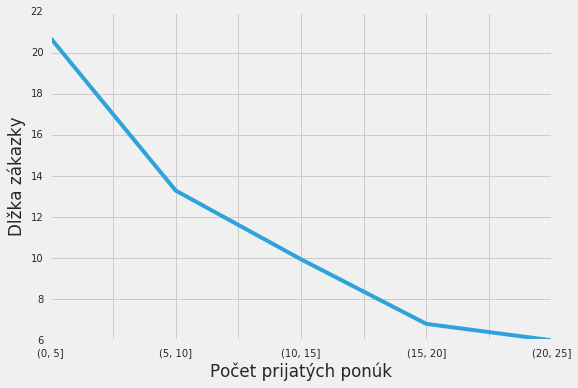

In [29]:
bins = [0, 5, 10, 15, 20 , 25]
df['categories_pocet_prijatych'] = pd.cut(df['pocet_prijatych_ponuk'], bins)
df.head()
df.groupby('categories_pocet_prijatych')['dlzka_zakazky_cleaned'].mean().plot(kind = 'line',)
plt.ylabel('Dlžka zákazky')
plt.xlabel('Počet prijatých ponúk')

Nasledujúci graf efektívne zachycuje rozdelenie pomeru cien medzi odhadovanou a finálnou cenou a členením zákazok podľa druhu zákazky a druhu postupu. Je možné vidieť, že najlacnejšie boli vysúťažené zákazky typu práce, potom nasledujú služby a nakoniec tovary. Vertikálna čiara však zobrazuje odchylku, ktorá je najmä pri prácach pomerne vysoká. Rozdiely medzi druhmi postupov sú signifikantné iba pri kategórií služieb. 

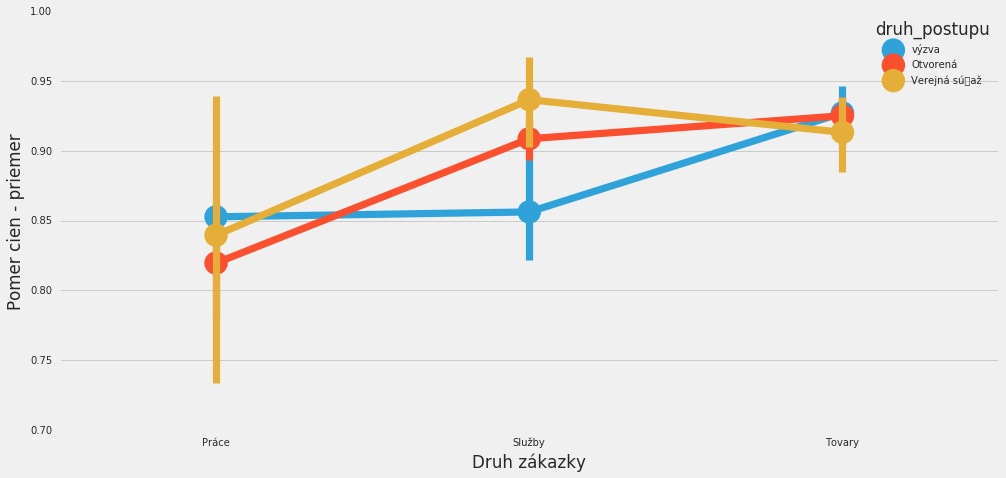

In [30]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15,7)
sns.pointplot(ax= ax1, x="druh_zakazky", y="price_ratio", hue = "druh_postupu", data=df)
plt.ylabel('Pomer cien - priemer')
plt.xlabel('Druh zákazky')

Pre nasledujúci graf musela byť zmenená škála, kvôli nadmerne vysokým priemerným finálnym cenám pri stavebných prácach. Obecne je tiež možné vidieť, že pri výzvach je táto priemerná cena podstatne nižšia naprieč všetkými kategóriami. 

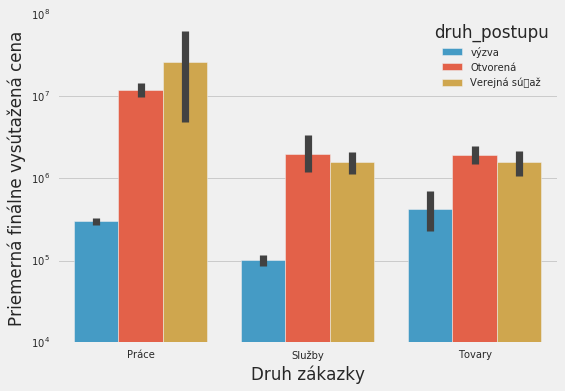

In [32]:
fig, ax2 = plt.subplots()
g = sns.barplot(ax = ax2, x="druh_zakazky", y="total_final_value_amount_clean", hue="druh_postupu", data=df)
g.set_yscale('log')
plt.ylabel('Priemerná finálne vysútažená cena')
plt.xlabel('Druh zákazky')
plt.show()

Z časového hľadiska bol analyzovaný počet odoslaných zákaziek v roku 2016 po jednotlivých mesiacoch. Zaujímovsťou je ich vyšší počet v prvom kvartáli roka, čo mohlo byť spôsobené blížiacim sa koncom volebného obdobia, ktoré nastalo v marci 2016. 

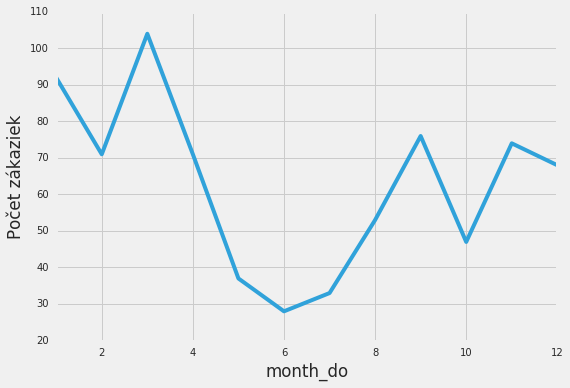

In [13]:
import datetime as dt
df['odoslanie_oznamenia_dt'] = pd.to_datetime(df['odoslanie_oznamenia'], format='%Y/%m/%d')
df['year_do'] = df['odoslanie_oznamenia_dt'].dt.year
df['quarter_do'] = df['odoslanie_oznamenia_dt'].dt.quarter
df['month_do'] = df['odoslanie_oznamenia_dt'].dt.month

df['dummy'] = 1

mask = df['year_do'] == 2016
plt.ylabel('Počet zákaziek')
plt.xlabel('Mesiace v roku 2016')
df[mask].groupby('month_do')['dummy'].sum().plot(kind = 'line',)

Nasleduje zobrazenie iba neefektívne vydražených zákaziek v 3 vizualizáciách. V jednotlivých segmentoch sú zobrazené iba kategórie s ich najvyšším celkovým počtom. 

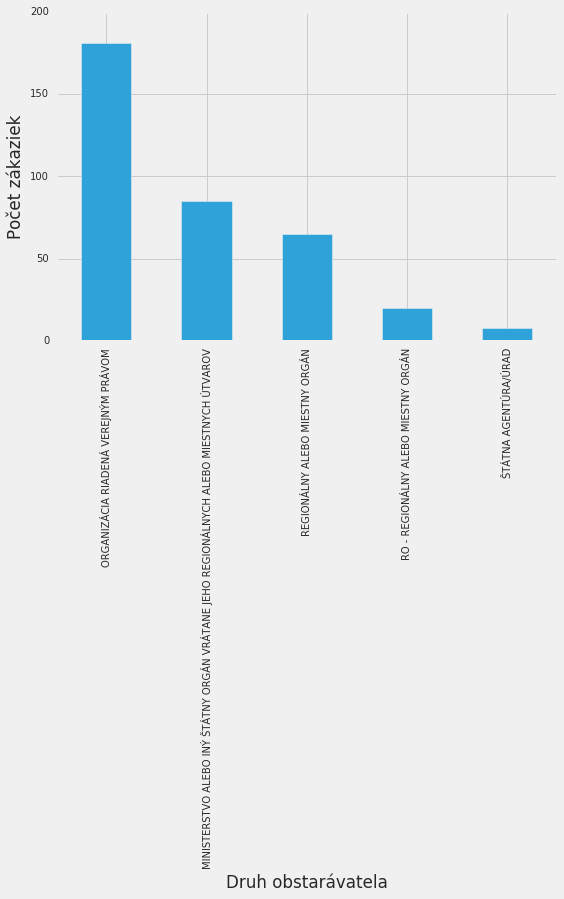

In [14]:
mask_target = df['target'] == 1 
df[mask_target].groupby(['druh_obstaravatela_clean'])['dummy'].sum().sort_values(ascending=False)[:5].plot(kind = 'bar')
plt.ylabel('Počet zákaziek')
plt.xlabel('Druh obstarávatela')

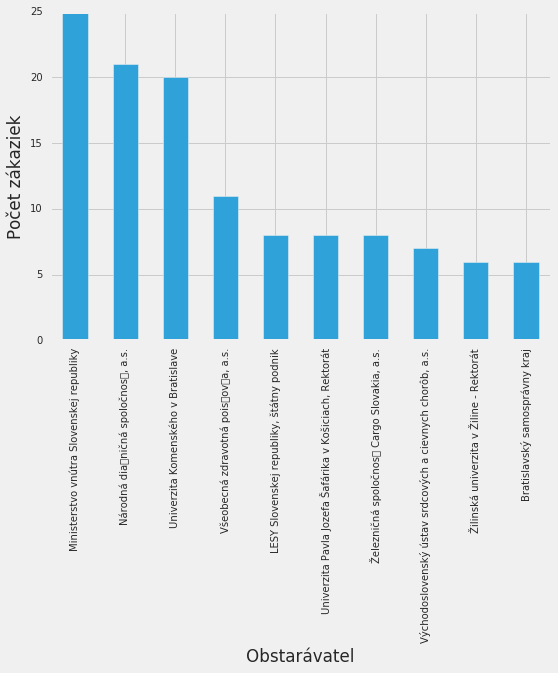

In [15]:
df[mask_target].groupby(['contracting_authority_name'])['dummy'].sum().sort_values(ascending=False)[:10].plot(kind = 'bar')
plt.ylabel('Počet zákaziek')
plt.xlabel('Obstarávatel')

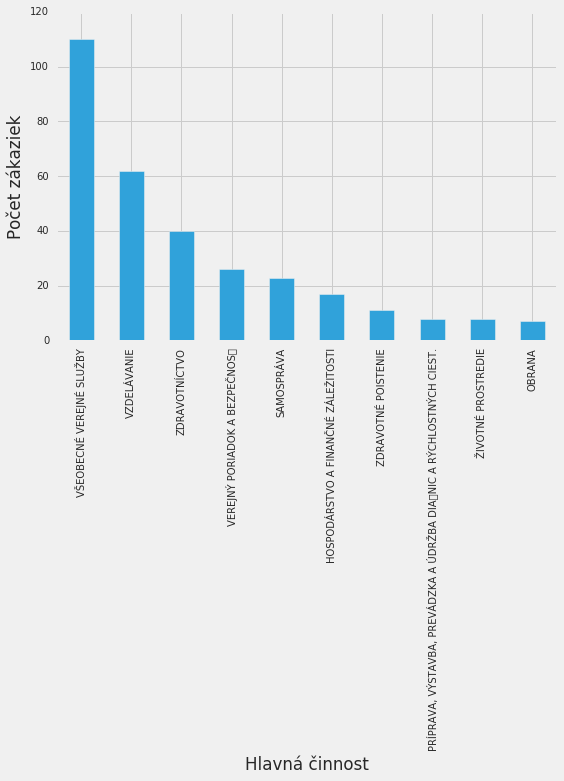

In [16]:
df[mask_target].groupby(['hlavna_cinnost_clean'])['dummy'].sum().sort_values(ascending=False)[:10].plot(kind = 'bar')
plt.ylabel('Počet zákaziek')
plt.xlabel('Hlavná činnost')

Nasledujúci graf zobrazuje prekvapivú informácu o vyššej konkurencii, pri nevyužití elektronickej aukcie. Očakávaný bol opačný efekt a táto informácia môže slúžiť napríklad k prešetreniu komplexnosti a efektivity procesu pri využití elektronickej aukcie. Pri analyzovaní pomeru cien odhadovanej a finálnej ceny vysvitlo, že boli v priemere dokonca drahšie vysúťažené zákazky s použitou elektronickou aukciou. 

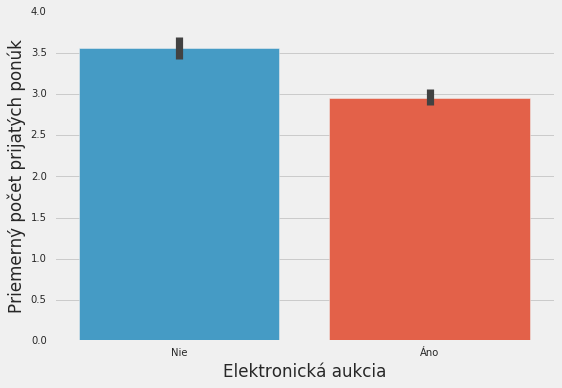

In [33]:
sns.barplot(x="el_aukcia", y="pocet_prijatych_ponuk", data=df)    
plt.ylabel('Priemerný počet prijatých ponúk')
plt.xlabel('Elektronická aukcia')

# Modelovacia časť

V modelovacej časti v Jupyter notebook na platforme Google cloud je zámerom ukázať využitie cloudových zdrojov v kombinácií s nástrojmi pre strojové učenie ako je scikit learn. Využité sú tiež rozdielne postupy oproti ukážke v Azure ML Studio s príkladom under samplingu prevažujúcej triedy cieľového atribútu. Výsledky modelovania sú v závere vizualizované spolu so zobrazením významnosti atribútov. Prvotne využitá je knižnica patsy, pomocou ktorej je vytvorený tzv. design matrix. Knižnica scikit-learn nedokáže pracovať s kategoriálnymi premennými a úlohou balíka je rozdelenie takýchto atribútov podľa hodnôt s vyplnenými hodnotami 0 a 1 (tzv. dummmy columns). Definovaný je tiež cieľový atribút - binárny s hodnotami 0, 1 vyjadrujúci, či ide o neefektívnu zákazku z pohľadu finálnej ceny a prediktori pochádzajúce z oznámení zákaziek. Neskôr je odložená tzv. testovacia množina bokom pre účely vyhodnotenia efektívnosti modelu na množine dát, ktorú pred tým nevidel.

In [5]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

Y,X = dmatrices('target ~ 0 + hlavna_cinnost_clean + druh_obstaravatela_clean + contracting_authority_name + druh_postupu + druh_zakazky + main_cpv_code + typ_obdobie + dlzka_zakazky_cleaned + kriteria_ponuk + el_aukcia + eu_fondy + estimatedpricecleaned + nazov_typu_oznamenia + miesto_prac_zakazky',df_clean, return_type = 'dataframe')

print(pd.DataFrame(Y,columns=['target'])['target'].value_counts()) #distribucia pred rozdelenim na trenovaciu a testovaciu mnozinu

X_train,X_test,Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

print(pd.DataFrame(Y_train,columns=['target'])['target'].value_counts()) #distribucia po rozdeleni na trenovaciu a testovaciu mnozinu

X_columns = X_train.columns

sm = RandomUnderSampler() #pouzitie metody under samplingu pre vyrovnanie trenovacej mnoziny
X_train, Y_train = sm.fit_sample(X_train, Y_train)

print(pd.DataFrame(Y_train,columns=['target'])['target'].value_counts()) #distribucia po prevedeni under samplingu trenovacej mnoziny

X_train = pd.DataFrame(X_train,columns=X_columns)

0.0    1944
1.0     478
Name: target, dtype: int64
0.0    1360
1.0     335
Name: target, dtype: int64
1.0    335
0.0    335
Name: target, dtype: int64


Zobrazenie vyrovnania cieľového atribútu pre účely trénovania modelu. Distribúcia na testovacej množine bola zachovaná z dôvodu vyhodnocovania na distribúcií "reálneho sveta". Výhodou vyrovnanej trénovacej množiny však je lepšie naučenie sa rozdielov medzi danými triedami a dosahovania lepšej výkonnosti pri pohľade na nami skúmanú triedu neefektívnych zákaziek.  

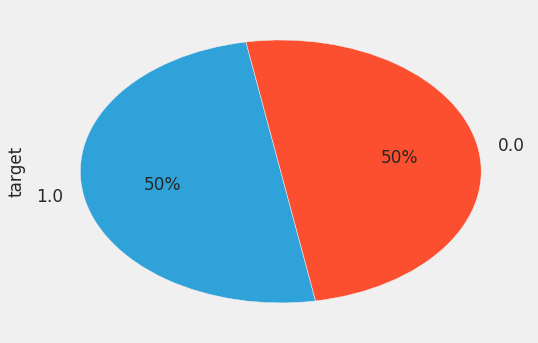

In [19]:
Y_df = pd.DataFrame(Y_train,columns=['target'])
Y_df['target'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)

Súčasťou danej distribúcie Pythonu sú baliky ako RandomizedSearchCV, prípadne GridSearchCV. Tieto balíky sú efektívne a ľahko použiteľné pre hľadanie vhodných parametrov modelu z pohľadu výkonnosti. Nakoniec však tieto metódy neboli využité kvôli neschopnosti vyhodnocovať výsledky na nevidenej - testovacej množine dát s pôvodnou distribúciou reálneho sveta. Poskytujú možnosť cross-validácie z trénovacej množiny, avšak tá už bola pozmenená v predchádzajúcom kroku pomocou under-samplingu. Kvôli danému faktu bola vyvinutá vlastná implementácia pre hľadanie najlepších parametrov s použitím algoritmu Random Forest a s vyhodnocovaním na testovacej množine. Metrika F1 bola využitá kvôli zameraniu sa na minoritnú triedu s tým, že môže byť interpretovaná ako vážený priemer dvoch dôležitých metrík z pohľadu minoritnej triedy - precision a recall. Model s najlepšími výsledkami bol nakoniec uložený a použitý vo finálnom kroku pre trénovanie.

In [8]:
import random

results = []

for i in range(250): #vlastna implementacia hladania najlepsich hyperparameters, kvoli potrebe vyhodnocovania na testovacej mnozine
    model_forest = RandomForestClassifier(max_depth=random.randint(1, 200),max_features=random.randint(1,30))
    model_forest.fit(X_train,Y_train)
    precision = metrics.precision_score(Y_test,model_forest.predict(X_test))
    f1 = metrics.f1_score(Y_test,model_forest.predict(X_test))
    accuracy = metrics.accuracy_score(Y_test,model_forest.predict(X_test))
    auc = metrics.roc_auc_score(Y_test,model_forest.predict(X_test))
    recall = metrics.recall_score(Y_test,model_forest.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test,model_forest.predict(X_test),labels=[1,0])
    results.append([model_forest,precision,f1,accuracy,auc,recall,confusion_matrix]) #ukladanie parametrov modelov a vysledkov metrik na test mnozine

max_f1 = 0

for index,sublist in enumerate(results): #prechadzanie listu a hladanie parametrov modelu s najlepsim vysledkom
    if sublist[2] > max_f1:
        max_f1 = sublist[2]
        best_model = results[index]

final_model = best_model[0] #najlepsi model ulozeny ako final_model
print(final_model)
print(max_f1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=172, max_features=30, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.512195121951


Trénovanie modelu prebehlo na trénovacej množine dát a vyhodnocovanie na nevidenej testovacej množine. Vyhodnotené boli metriky dôležité pri posudzovaní výkonnosti binárneho klasifikačného problému vrátane matice zámen. Zobrazené metriky sú počítané z hodnôt tejto tabuľky. 

accuracy (presnosť) : (a+d) / (a+b+c+d) <br>
precision(presnosť/precíznosť): (a) / (a+c) <br>
recall(úplnosť, senzitivita): (a) / (a+b) <br>
F skóre: (2a) / (2a+b+c)

Natrénovaný model na testovacej množine dosahuje pomerne vysoké skóre úplnosti, teda zachytí väčšinu z pozitívnej triedy. Presnosť predikcíí tejto minoritnej triedy je následne takmer 40%. V reálnom svete vychádzajúc z nazbieraných dát existuje neefektívnych zákaziek iba 20%. 

In [45]:
final_model.fit(X_train,Y_train) #fitting prebieha na modeli s najlepsimi parametrami z predchadzuceho kroku
precision = metrics.precision_score(Y_test,final_model.predict(X_test)) #finalne vyhodnocovanie metrik na zatial nepouzitej test mnozine
f1 = metrics.f1_score(Y_test,final_model.predict(X_test))
accuracy = metrics.accuracy_score(Y_test,final_model.predict(X_test))
auc = metrics.roc_auc_score(Y_test,final_model.predict(X_test))
recall = metrics.recall_score(Y_test,final_model.predict(X_test))
confusion_matrix = metrics.confusion_matrix(Y_test,final_model.predict(X_test),labels=[1,0])

print('precision: ',precision )
print('recall: ', recall)
print('f1: ', f1)
print('accuracy: ', accuracy)
print('auc: ', auc)
print(confusion_matrix)

('precision: ', 0.39583333333333331)
('recall: ', 0.66433566433566438)
('f1: ', 0.4960835509138381)
('accuracy: ', 0.734525447042641)
('auc: ', 0.70802399655139381)
[[ 95  48]
 [145 439]]


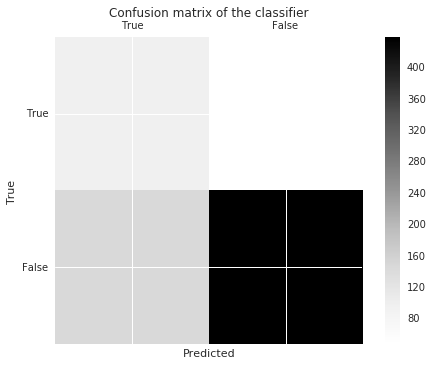

In [46]:
labels = ['True', 'False'] #vizualizacia confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix)
fig.colorbar(cax)
plt.title('Confusion matrix of the classifier')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Na záver sú vyobrazené významnosti prediktorov do prehľadného grafu. Ako bolo spomenuté, kategoriálne premenné boli rozdelené na viacero častí podľa ich hodnôt. Numerické premenné majú teda na prvý pohľad vyššiu významnosť. Z kategoriálnych atribútov sa medzi významené radia druh zákazky, či druh postupu.

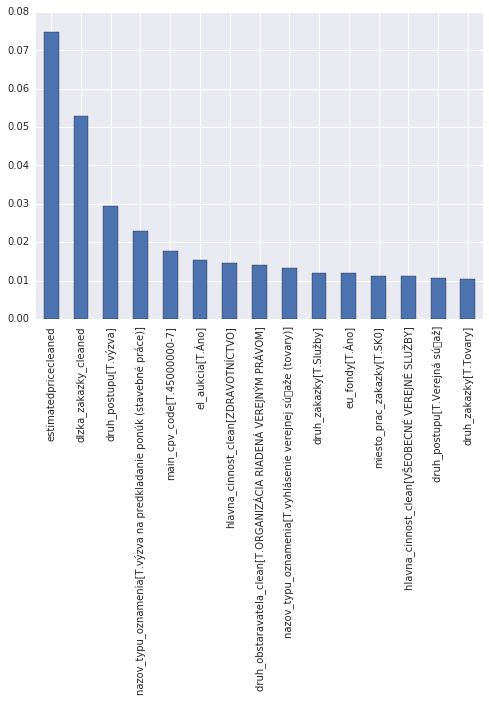

In [50]:
importance = sorted(zip(map(lambda x: round(x, 4), final_model.feature_importances_), X.columns),reverse=True) #analyza vyznamnosti prediktorov
y_val = []
x_val = [x[0] for x in importance]
for x in importance:
    y_val.append(x[1])
    
pd.Series(x_val,index=y_val)[:15].plot(kind='bar')
plt.show() #kategoricke prediktory su rozdelene na viacero casti

Pre úplnosť je vhodné na záver uchovať model pre budúce účely, prípadne využiť ho pre predikcie v súčasnom stave bez potreby trénovania v každom behu. Balík pickle dokáže model v takomto stave uchovať a bezpečne uložiť. 

In [ ]:
import pickle
model_pickled = pickle.dumps(final_model)